<h1 align="center"> SPAM Detector: Text Classify </h1>

<img src="https://raw.githubusercontent.com/deepankarkotnala/Email-Spam-Ham-Classifier-NLP/master/images/email_spam_ham.png" width="50%" />

Created: 2020-09-15

Last updated: 2020-09-15

Kaggle Kernel made by 🚀 <a href="https://www.kaggle.com/rafanthx13"> Rafael Morais de Assis</a>

This is an initial kernel, in the future it will be filled with the theoretical part and more details about NLP

## Problem Description

Classify SPAM or HAM

Meaning of HAM

> The term ‘ham’ was originally coined by SpamBayes sometime around 2001and is currently defined and understood to be “E-mail that is generally desired and isn't considered spam.” - [link](https://blog.barracuda.com/2013/10/03/ham-v-spam-whats-the-difference/)

https://blog.barracuda.com/2013/10/03/ham-v-spam-whats-the-difference/



## Table Of Contents (TOC) <a id="top"></a>

+ [Import Libs and DataSet](#index01) 
+ [Snippets](#index02)
+ [EDA](#index03)
+ [Text Cleaning](#index04)
  - [Def functions](#index05)
  - [Execute pre-processing](#index06)
+ [Split in train and Test](#index07)
+ [Develop Model](#index08)
+ [Evaluate Model](#index09)
+ [Conclusion](#index10)


## Import Libs and DataSet <a id='index01'></a>

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Configs
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [112]:
file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'
df = pd.read_csv(file_path, encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

print("DataSet = {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.head()

DataSet = 5572 rows and 2 columns


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Snippets <a id='index02'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [113]:
def eda_categ_feat_desc_plot(series_categorical, title = ""):
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)

    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], row['quantity'], color='black', ha="center")

    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot")

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

In [114]:
def plot_nn_loss_acc(history):
    fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    # summarize history for accuracy
    axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
    axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
    axis1.set_title('Model accuracy', fontsize=16)
    axis1.set_ylabel('accuracy')
    axis1.set_xlabel('epoch')
    axis1.legend(loc='upper left')
    # summarize history for loss
    axis2.plot(history.history['loss'], label='Train', linewidth=3)
    axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
    axis2.set_title('Model loss', fontsize=16)
    axis2.set_ylabel('loss')
    axis2.set_xlabel('epoch')
    axis2.legend(loc='upper right')
    plt.show()

In [115]:
def plot_words_distribution(mydf, target_column, title='Words distribution', x_axis='Words in column'):
    # adaptade of https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc
    # def statistics
    len_name = target_column +'_len'
    mydf[len_name] = np.array(list(map(len, mydf[target_column])))
    sw = mydf[len_name]
    median = sw.median()
    mean   = sw.mean()
    mode   = sw.mode()[0]
    # figure
    fig, ax = plt.subplots()
    sns.distplot(mydf[len_name], bins=mydf[len_name].max(),
                hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
                kde_kws={"color": "black", 'linewidth': 3})
    ax.set_xlim(left=0, right=np.percentile(mydf[len_name], 95)) # Dont get outiliers
    ax.set_xlabel(x_axis)
    ymax = 0.025
    plt.ylim(0, ymax)
    # plot vertical lines for statistics
    ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
    ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
    ax.plot([median, median], [0, ymax], '--', label=f'median = {median:.2f}', linewidth=4)
    ax.set_title(title, fontsize=20)
    plt.legend()
    plt.show()

In [116]:
import time

def time_spent(time0):
    t = time.time() - time0
    t_int = int(t) // 60
    t_min = t % 60
    if(t_int != 0):
        return '{}min {:.3f}s'.format(t_int, t_min)
    else:
        return '{:.3f}s'.format(t_min)

In [117]:
from sklearn.metrics import confusion_matrix, classification_report

this_labels = ['HAM','SPAM']

def class_report(y_real, y_my_preds, name="", labels=this_labels):
    if(name != ''):
        print(name,"\n")
    print(confusion_matrix(y_real, y_my_preds), '\n')
    print(classification_report(y_real, y_my_preds, target_names=labels))

## EDA <a id='index03'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [118]:
df['message_lenght'] = np.array(list(map(len, df['message'])))

min_len = df['message_lenght'].min()
max_len = df['message_lenght'].max()

print('min len:', min_len)
print(df[df.message_lenght == min_len].message.iloc[0], '\n')

print('max len:', max_len)
print(df[df.message_lenght == max_len].message.iloc[0])

df = df.drop(['message_lenght'], axis=1)

min len: 2
Ok 

max len: 910
For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


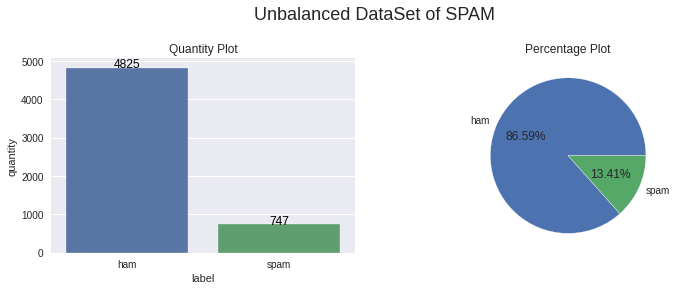

In [119]:
eda_categ_feat_desc_plot(df.label, 'Unbalanced DataSet of SPAM')

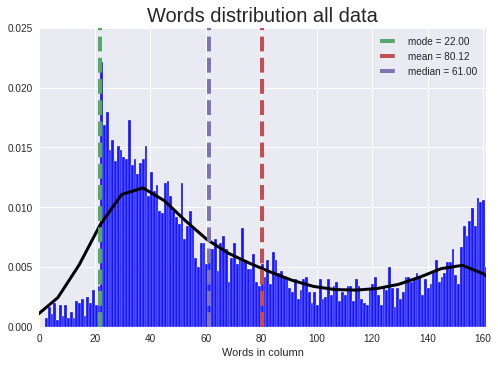

In [120]:
plot_words_distribution(df, 'message', title='Words distribution all data')

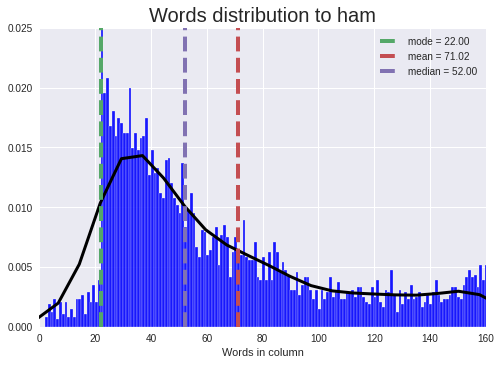

In [121]:
plot_words_distribution( df.query('label == "ham"'), 'message', title='Words distribution to ham')

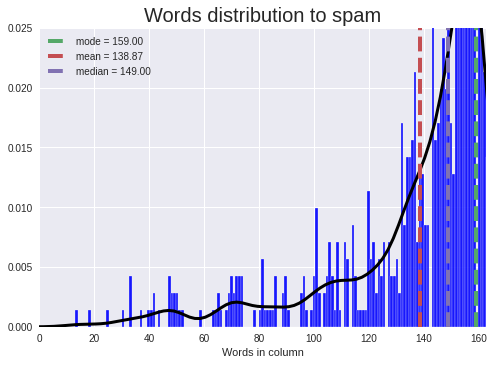

In [122]:
plot_words_distribution( df.query('label == "spam"'), 'message', title='Words distribution to spam')

## Text Cleaning <a id='index04'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

### Def functions <a id='index05'></a>

In [1]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
"couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
"hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would",
"I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
"i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
"i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
"it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
"sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
"she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
"shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
"this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
"there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
"they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
"weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
"where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
"who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
"why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
"y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
"y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will",
"you'll've": "you will have", "you're": "you are", "you've": "you have" }

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora',
'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

In [123]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [125]:
from nltk.corpus import stopwords
import re

# Stop Words in Python. Is better search in a 'set' structure
stops = set(stopwords.words("english"))  

def clean_text( text ):
    # 1. Remove non-letters        
    text = re.sub("[^a-zA-Z]", " ", text) 
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    # 2. Convert to lower case, split into individual words
    text = text.lower().split()                                             
    # 3. Remove stop words
    meaningful_words = [w for w in text if not w in stops]   
    # 4. Join the words back into one string separated by space.
    return( " ".join( meaningful_words )) 

In [126]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lematizer(text):
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

### Execute Text Pre-Procesing <a id='index06'></a>

In [127]:
clean_column = 'clean_message'

df[clean_column] = df['message'].apply(lambda x: clean_contractions(x, contraction_mapping))

df[clean_column] = df[clean_column].apply(lambda x: correct_spelling(x, mispell_dict))

df[clean_column] = df[clean_column].apply(clean_text)

df[clean_column] = df[clean_column].apply(lematizer)


## Split in train and test <a id='index07'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>


In [128]:
from sklearn.model_selection import train_test_split

X = df[clean_column].values
y = df['label'].replace({'ham': 0, 'spam': 1})

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Develop Model <a id='index08'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [129]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [130]:
# Tokenizer
maxlen = 130
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(np.concatenate((x_train, x_test), axis=0))

In [131]:
# Convert x_train
list_tokenized_train = tokenizer.texts_to_sequences(x_train) # convert string to numbers, 
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # create a array of 130 spaces and put all words in end

## Convert x_test
X_tt = tokenizer.texts_to_sequences(x_test)
X_tt = pad_sequences(X_tt, maxlen=maxlen)

In [132]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 5
history = model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, validation_data=(X_tt, y_test))

Epoch 1/5
36/36 [==============================] - 5s 142ms/step - loss: 0.4617 - accuracy: 0.8670 - val_loss: 0.3736 - val_accuracy: 0.8621
Epoch 2/5
36/36 [==============================] - 4s 119ms/step - loss: 0.2693 - accuracy: 0.8788 - val_loss: 0.1533 - val_accuracy: 0.9686
Epoch 3/5
36/36 [==============================] - 4s 121ms/step - loss: 0.0835 - accuracy: 0.9826 - val_loss: 0.0899 - val_accuracy: 0.9843
Epoch 4/5
36/36 [==============================] - 4s 118ms/step - loss: 0.0360 - accuracy: 0.9893 - val_loss: 0.0765 - val_accuracy: 0.9832
Epoch 5/5
36/36 [==============================] - 5s 131ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.0955 - val_accuracy: 0.9854


## Evaluate Model <a id='index09'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [133]:
y_pred = model.predict_classes(X_tt)

class_report(y_test, y_pred, "Keras Neural Net LSTM")

Keras Neural Net LSTM 

[[962   3]
 [ 13 137]] 

              precision    recall  f1-score   support

         HAM       0.99      1.00      0.99       965
        SPAM       0.98      0.91      0.94       150

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



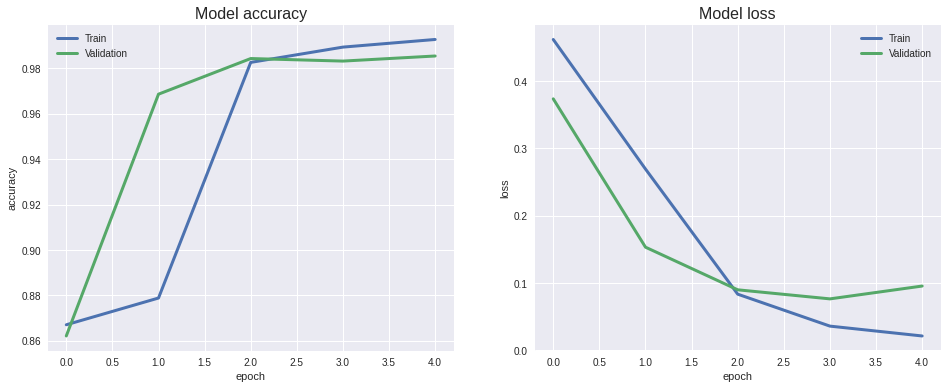

In [134]:
plot_nn_loss_acc(history)

## Hyper Tuning a RandomForest

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(np.concatenate((x_train, x_test), axis=0))

X_train_dtm = vect.transform(x_train)
X_test_dtm = vect.transform(x_test)
x_full_dtm = vect.transform( np.concatenate((x_train, x_test), axis=0) )

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit( x_full_dtm )
X_train_dtm_tfft = tfidf_transformer.transform(X_train_dtm)
X_test_dtm_tfft  = tfidf_transformer.transform(X_test_dtm)

In [136]:
from sklearn.model_selection import GridSearchCV

def optimize_random_forest(mx_train, my_train, my_hyper_params, hyper_to_search, hyper_search_name, cv=4, scoring='accuracy'):
    """search best param to unic one hyper param
    @mx_train, @my_train = x_train, y_train of dataset
    @my_hyper_params: dict with actuals best_params: start like: {}
      => will be accumulated and modified with each optimization iteration
      => example stater: best_hyper_params = {'random_state': 42, 'n_jobs': -1}
    @hyper_to_search: dict with key @hyper_search_name and list of values to gridSearch:
    @hyper_search_name: name of hyperparam
    """
    if(hyper_search_name in my_hyper_params.keys()):
        del my_hyper_params[hyper_search_name]
    if(hyper_search_name not in hyper_to_search.keys()):
        raise Exception('"hyper_to_search" dont have {} in dict'.format(hyper_search_name))
        
    t0 = time.time()
        
    rf = RandomForestClassifier(**my_hyper_params)
    
    grid_search = GridSearchCV(estimator = rf, param_grid = hyper_to_search, 
      scoring = scoring, n_jobs = -1, cv = cv)
    grid_search.fit(mx_train, my_train)
    
    print('took', time_spent(t0))
    
    data_frame_results = pd.DataFrame(
        data={'mean_fit_time': grid_search.cv_results_['mean_fit_time'],
        'mean_test_score_'+scoring: grid_search.cv_results_['mean_test_score'],
        'ranking': grid_search.cv_results_['rank_test_score']
         },
        index=grid_search.cv_results_['params']).sort_values(by='ranking')
    
    print('The Best HyperParam to "{}" is {} with {} in {}'.format(
        hyper_search_name, grid_search.best_params_[hyper_search_name], grid_search.best_score_, scoring))
    
    my_hyper_params[hyper_search_name] = grid_search.best_params_[hyper_search_name]
    
    """
    @@my_hyper_params: my_hyper_params appends best param find to @hyper_search_name
    @@data_frame_results: dataframe with statistics of gridsearch: time, score and ranking
    @@grid_search: grid serach object if it's necessary
    """
    return my_hyper_params, data_frame_results, grid_search

In [137]:
best_hyper_params = {'random_state': 42, 'n_jobs': -1} # Stater Hyper Params

In [138]:
search_hyper = {'min_samples_split': [2, 5, 10]}

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'min_samples_split')

took 15.847s
The Best HyperParam to "min_samples_split" is 10 with 0.9768899292333206 in accuracy


In [139]:
search_hyper = {'n_estimators': [50, 100, 200, 400, 800, 1600, 2000] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'n_estimators')

took 3min 21.826s
The Best HyperParam to "n_estimators" is 200 with 0.9780120118185991 in accuracy


In [140]:
search_hyper = { 'max_depth': [100, 110, 115, 200, 400, None] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'max_depth')

results

took 50.943s
The Best HyperParam to "max_depth" is 400 with 0.9780120118185991 in accuracy


,mean_fit_time,mean_test_score_accuracy,ranking
{'max_depth': 400},7.2972,0.9780,1
{'max_depth': None},7.0975,0.9780,1
{'max_depth': 110},7.1670,0.9778,3
{'max_depth': 200},7.4270,0.9778,3
{'max_depth': 115},7.5000,0.9778,5
{'max_depth': 100},8.8342,0.9769,6


In [141]:
search_hyper = { 'max_features': ['auto', 'log2', None] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'max_features')

results

took 39.095s
The Best HyperParam to "max_features" is auto with 0.9780120118185991 in accuracy


,mean_fit_time,mean_test_score_accuracy,ranking
{'max_features': 'auto'},7.4182,0.9780,1
{'max_features': None},17.8012,0.9735,2
{'max_features': 'log2'},8.8902,0.9702,3


In [142]:
search_hyper = { 'criterion' :['gini', 'entropy'] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'criterion')

took 18.783s
The Best HyperParam to "criterion" is gini with 0.9780120118185991 in accuracy


In [143]:
search_hyper = { 'min_samples_split' :[ 8, 9, 10, 11, 12] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'min_samples_split')

took 42.271s
The Best HyperParam to "min_samples_split" is 11 with 0.9784606435822915 in accuracy


In [144]:
search_hyper = { 'max_leaf_nodes' :[ 2, 100, 200, 300, 400, None] }

best_hyper_params, results, last_grid_search = optimize_random_forest(
    X_train_dtm, y_train, best_hyper_params, search_hyper, 'max_leaf_nodes')

took 41.511s
The Best HyperParam to "max_leaf_nodes" is None with 0.9784606435822915 in accuracy


In [146]:
best_hyper_params

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 200,
 'max_depth': 400,
 'max_features': 'auto',
 'criterion': 'gini',
 'min_samples_split': 11,
 'max_leaf_nodes': None}

In [147]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier() 
forest = forest.fit(X_train_dtm, y_train)
y_pred = forest.predict(X_test_dtm)

class_report(y_test, y_pred, 'Random Forest Normal')

Random Forest Normal 

[[964   1]
 [ 30 120]] 

              precision    recall  f1-score   support

         HAM       0.97      1.00      0.98       965
        SPAM       0.99      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [148]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(**best_hyper_params) 
forest = forest.fit(X_train_dtm, y_train)
y_pred = forest.predict(X_test_dtm)

class_report(y_test, y_pred, 'Random Forest HyperTuned')

Random Forest HyperTuned 

[[965   0]
 [ 23 127]] 

              precision    recall  f1-score   support

         HAM       0.98      1.00      0.99       965
        SPAM       1.00      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Conclusion <a id='index10'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

**References**

https://www.kaggle.com/nilanml/imdb-review-deep-model-94-89-accuracy

This is an initial kernel, in the future it will be filled with the theoretical part and more details about NLP, how a kernel to start understand NLP.